### Download fastText and facebook infersent models
Followed steps at: https://github.com/facebookresearch/InferSent

In [1]:
import nltk
nltk.download('punkt')
import sys
sys.path.append("../lib/InferSent")
from models import InferSent
import torch
import pandas as pd
import spacy
import numpy as np
from tqdm.notebook import tqdm

[nltk_data] Downloading package punkt to /home/ryan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048, 'pool_type': 'max', 'dpout_model': 0.0, 'version': 2}
infersent = InferSent(params_model)
infersent.load_state_dict(torch.load('../models/encoder/infersent2.pkl'))
infersent.set_w2v_path("../models/fastText/crawl-300d-2M.vec")

In [3]:
squad_df = pd.read_csv("../corpora/squad-dev-v2.0.csv", index_col=0)
squad_df.head()

,contexts,questions,answer_texts,answer_starts
0,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,France,159
1,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,10th and 11th centuries,94
2,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,in the 10th and 11th centuries,87
3,The Normans (Norman: Nourmands; French: Norman...,From which countries did the Norse originate?,"Denmark, Iceland and Norway",256
4,The Normans (Norman: Nourmands; French: Norman...,Who was the Norse leader?,Rollo,308


In [4]:
pd.set_option('max_colwidth', 100)
squad_df.sample(5)

,contexts,questions,answer_texts,answer_starts
4899,"In cases where the criminalized behavior is pure speech, civil disobedience can consist simply o...",What is one way of digital civil disobedience that can have far reaching consequences?,Supreme Court case,265
755,Formed in November 1990 by the equal merger of Sky Television and British Satellite Broadcasting...,Who is the UK's largest digital subscription television company?,BSkyB,98
588,The state is most commonly divided and promoted by its regional tourism groups as consisting of ...,Which mountain range influenced the split of the regions?,Tehachapis,538
5088,Large-scale construction requires collaboration across multiple disciplines. An architect normal...,Who normally supervises a construction job?,"a construction manager, design engineer, construction engineer or project manager",120
5563,"Jacksonville is the largest city by population in the U.S. state of Florida, and the largest cit...","Based on population alone, what is Jacksonville's ranking in the United States?",12th,472


In [5]:
nlp = spacy.load("en")

In [6]:
sentences = []

contexts = list(squad_df["contexts"].drop_duplicates())
for context in contexts:
    doc = nlp(context)
    sentences += [sentence.string.strip() for sentence in doc.sents]

In [7]:
infersent.build_vocab(sentences, tokenize=True)

Found 18481(/19809) words with w2v vectors
Vocab size : 18481


In [8]:
embeddings = infersent.encode(sentences, tokenize=True)

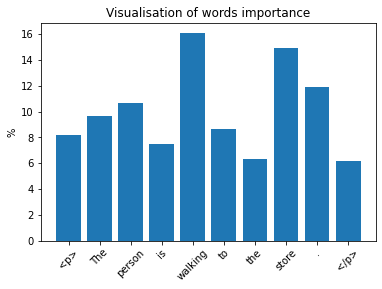

(tensor([[ 0.0075, -0.0281,  0.0683,  ..., -0.0171, -0.0331, -0.0084]],
        grad_fn=<MaxBackward0>),
 array([[0, 2, 4, ..., 7, 5, 1]]))

In [9]:
infersent.visualize('The person is walking to the store.', tokenize=True)

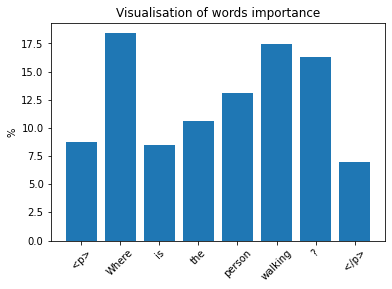

(tensor([[ 0.0075, -0.0292,  0.0551,  ..., -0.0055, -0.0356, -0.0193]],
        grad_fn=<MaxBackward0>),
 array([[0, 1, 5, ..., 3, 6, 1]]))

In [10]:
infersent.visualize('Where is the person walking?', tokenize=True)

In [11]:
def cosine_similarity(text1, text2):
    return np.dot(text1, text2)/(np.linalg.norm(text1) * np.linalg.norm(text2))

In [12]:
def split_sentences(paragraph):
    doc = nlp(paragraph)
    return [sentence.string.strip() for sentence in doc.sents]

In [13]:
def cosine_predict(statements, question):
    context_sentences = split_sentences(statements)
    most_similar, highest_sim = "", 0
    for sentence in context_sentences:
        similarity = cosine_similarity(infersent.encode([question])[0], infersent.encode([sentence])[0])
        if similarity > highest_sim:
            most_similar = sentence
            highest_sim = similarity
    return most_similar, highest_sim

In [24]:
len(squad_df)

10388

In [14]:
sample_size = len(squad_df) # 10388
correct_answers = 0
for i, row in tqdm(squad_df.iterrows(), total=sample_size):
    most_similar, _ = cosine_predict(row["contexts"], row["questions"])    
    correct_answers += 1 if row["answer_texts"] in most_similar else 0
print(f"Cosine Similarity Accuracy: {correct_answers/sample_size}")


Cosine Similarity Accuracy: 0.6523873700423566


In [15]:
# sample = squad_df.sample(n=1).iloc(0)[0]
sample = squad_df.iloc[7629]
sample.head()

contexts         Prime numbers have influenced many artists and writers. The French composer Olivier Messiaen use...
questions                                           Which French composer wrote ametrical music using prime numbers?
answer_texts                                                                                        Olivier Messiaen
answer_starts                                                                                                     76
Name: 7629, dtype: object

In [16]:
sample.contexts

'Prime numbers have influenced many artists and writers. The French composer Olivier Messiaen used prime numbers to create ametrical music through "natural phenomena". In works such as La Nativité du Seigneur (1935) and Quatre études de rythme (1949–50), he simultaneously employs motifs with lengths given by different prime numbers to create unpredictable rhythms: the primes 41, 43, 47 and 53 appear in the third étude, "Neumes rythmiques". According to Messiaen this way of composing was "inspired by the movements of nature, movements of free and unequal durations".'

In [17]:
statements = split_sentences(sample["contexts"])
options = {"compact": True, "bg": "#323a48", "color": "white", "font": "Source Sans Pro"}
spacy.displacy.render(nlp(statements[0]), style="dep", options=options)

In [18]:
statements

['Prime numbers have influenced many artists and writers.',
 'The French composer Olivier Messiaen used prime numbers to create ametrical music through "natural phenomena".',
 'In works such as La Nativité du Seigneur (1935) and Quatre études de rythme (1949–50), he simultaneously employs motifs with lengths given by different prime numbers to create unpredictable rhythms: the primes 41, 43, 47 and 53 appear in the third étude, "Neumes rythmiques".',
 'According to Messiaen this way of composing was "inspired by the movements of nature, movements of free and unequal durations".']

In [19]:
cosine_predict(sample.contexts, sample.questions)

('The French composer Olivier Messiaen used prime numbers to create ametrical music through "natural phenomena".',
 0.73706377)

In [20]:
statements = "The air was cold. The cat was orange. The cat walked across the grass. A bird flew in the sky."
question = "Where did the cat walk?"
cosine_predict(statements, question)

('The cat walked across the grass.', 0.48702255)

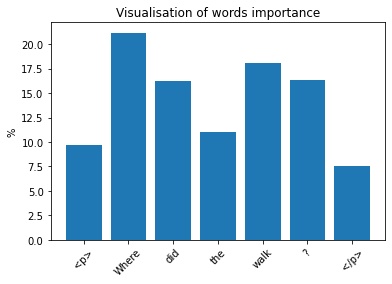

(tensor([[ 0.0075, -0.0292,  0.0664,  ...,  0.0401,  0.0146, -0.0329]],
        grad_fn=<MaxBackward0>),
 array([[0, 1, 4, ..., 2, 4, 5]]))

In [21]:
infersent.visualize(question, tokenize=True)

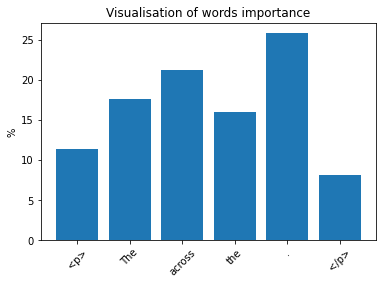

(tensor([[ 0.0075, -0.0695,  0.0447,  ..., -0.0573,  0.0130, -0.0139]],
        grad_fn=<MaxBackward0>),
 array([[0, 1, 2, ..., 2, 2, 4]]))

In [22]:
infersent.visualize("The cat walked across the grass.", tokenize=True)

In [23]:
# TODO: Random Forest, Log Regression, RNN, AWD-LSTM, Make class for QA model to seed chatbot text gen